In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# install library
! pip install -q kaggle

In [3]:
# import files class to upload files to colab
from google.colab import files

In [4]:
# upload kaggle.json
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"georgiostsarouchas","key":"b5c59161427c6ebbaa08ab781b2673a4"}'}

In [5]:
# Make directory named kaggle and copy kaggle.json file there.
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, concatenate, Input
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Dense, Add, DepthwiseConv2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50,VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.callbacks import EarlyStopping,LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
plt.rcParams['font.size'] = 16
import os
import cv2
from tensorflow.keras import utils
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms, models
from PIL import Image

In [7]:
! kaggle datasets download -d andrewmvd/medical-mnist

 96% 81.0M/84.8M [00:01<00:00, 81.2MB/s]
100% 84.8M/84.8M [00:01<00:00, 64.4MB/s]


In [ ]:
!ls -l

total 86860
-rw-r--r-- 1 root root       69 Jul  6 07:41 kaggle.json
-rw-r--r-- 1 root root 88933634 Jul  6 07:41 medical-mnist.zip
drwxr-xr-x 1 root root     4096 Jun 30 13:34 sample_data


In [8]:
! mkdir medical_mnist
! unzip medical-mnist.zip -d medical_mnist

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
  inflating: medical_mnist/HeadCT/005000.jpeg  
  inflating: medical_mnist/HeadCT/005001.jpeg  
  inflating: medical_mnist/HeadCT/005002.jpeg  
  inflating: medical_mnist/HeadCT/005003.jpeg  
  inflating: medical_mnist/HeadCT/005004.jpeg  
  inflating: medical_mnist/HeadCT/005005.jpeg  
  inflating: medical_mnist/HeadCT/005006.jpeg  
  inflating: medical_mnist/HeadCT/005007.jpeg  
  inflating: medical_mnist/HeadCT/005008.jpeg  
  inflating: medical_mnist/HeadCT/005009.jpeg  
  inflating: medical_mnist/HeadCT/005010.jpeg  
  inflating: medical_mnist/HeadCT/005011.jpeg  
  inflating: medical_mnist/HeadCT/005012.jpeg  
  inflating: medical_mnist/HeadCT/005013.jpeg  
  inflating: medical_mnist/HeadCT/005014.jpeg  
  inflating: medical_mnist/HeadCT/005015.jpeg  
  inflating: medical_mnist/HeadCT/005016.jpeg  
  inflating: medical_mnist/HeadCT/005017.jpeg  
  inflating: medical_mnist/HeadCT/005018.jpeg  
  inflating: medical_mnist/HeadCT

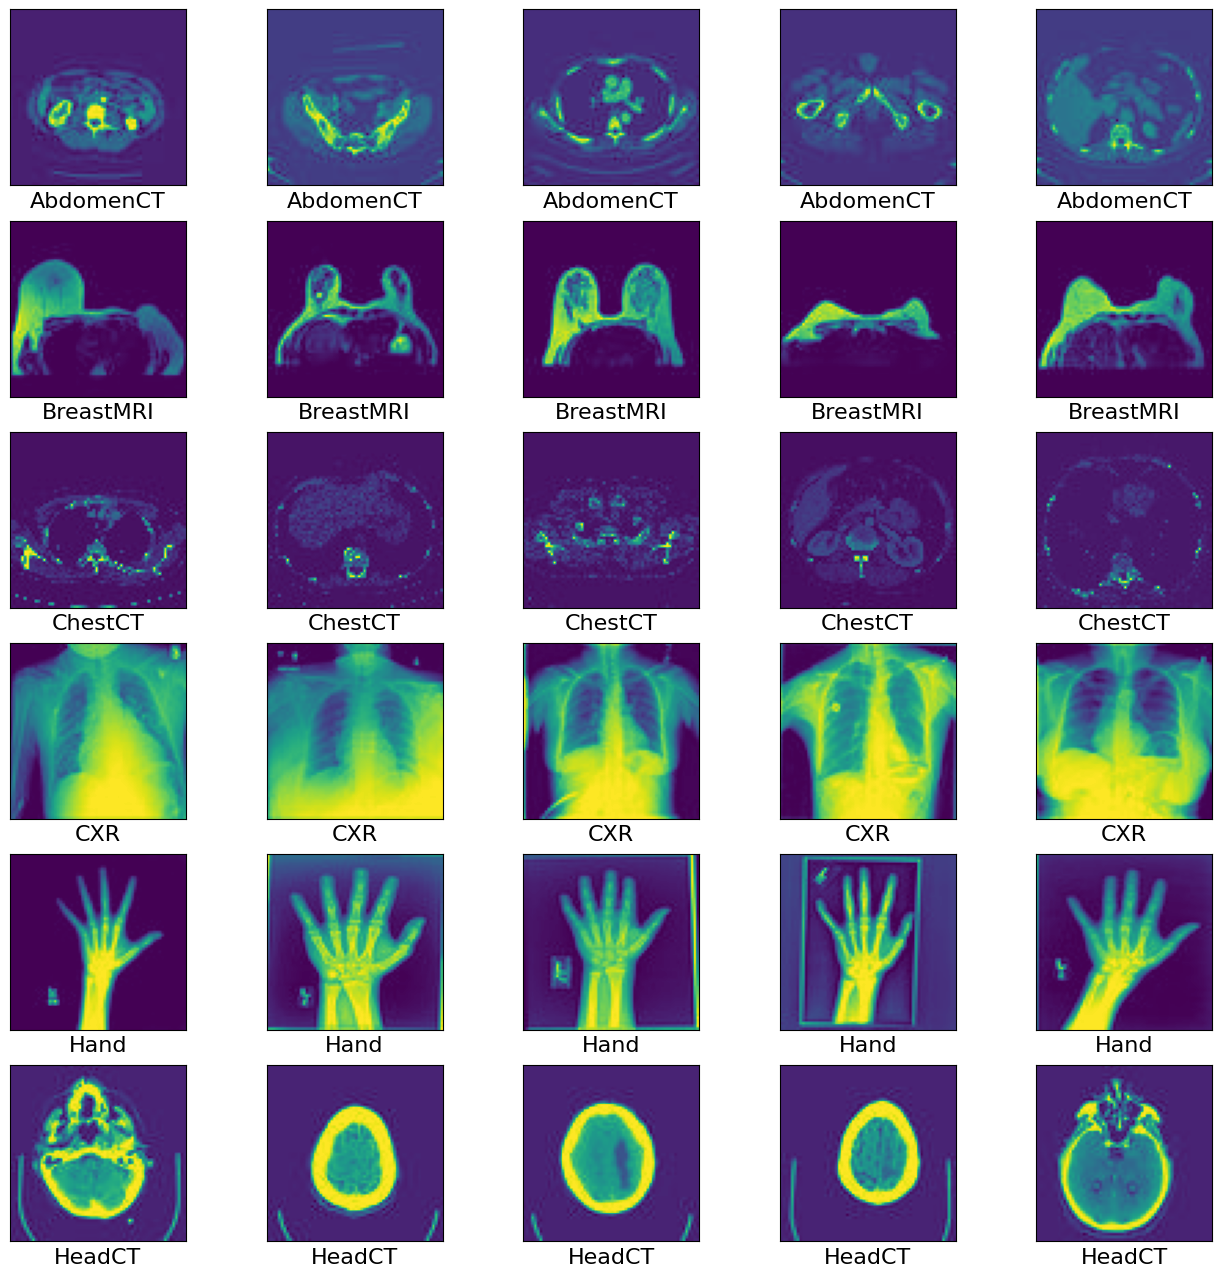

In [9]:
#plot few images
AbdomenCT_dir = 'medical_mnist/AbdomenCT/'
BreastMRI_dir = 'medical_mnist/BreastMRI/'
ChestCT_dir = 'medical_mnist/ChestCT/'
CXR_dir = 'medical_mnist/CXR/'
Hand_dir = 'medical_mnist/Hand/'
HeadCT_dir = 'medical_mnist/HeadCT/'
classes = ['AbdomenCT', 'BreastMRI','ChestCT','CXR','Hand','HeadCT']
AbdomenCT_img = [im for im in os.listdir('medical_mnist/AbdomenCT')
              if any(im.endswith(ext) for ext in ['jpg','png','jpeg'])]
BreastMRI_img = [im for im in os.listdir('medical_mnist/BreastMRI')
              if any(im.endswith(ext) for ext in ['jpg','png','jpeg'])]
ChestCT_img = [im for im in os.listdir('medical_mnist/ChestCT')
              if any(im.endswith(ext) for ext in ['jpg','png','jpeg'])]
CXR_img = [im for im in os.listdir('medical_mnist/CXR')
              if any(im.endswith(ext) for ext in ['jpg','png','jpeg'])]
Hand_img = [im for im in os.listdir('medical_mnist/Hand')
              if any(im.endswith(ext) for ext in ['jpg','png','jpeg'])]
HeadCT_img = [im for im in os.listdir('medical_mnist/HeadCT')
              if any(im.endswith(ext) for ext in ['jpg','png','jpeg'])]
plt.figure(figsize=(16, 16))
for i in range(30):
  plt.subplot(6,5,i+1)
  plt.xticks([])
  plt.yticks([])
  if i < 5:
    path = AbdomenCT_dir + AbdomenCT_img[i]
    plt.xlabel(classes[0])
  elif 5 <= i < 10:
    path = BreastMRI_dir + BreastMRI_img[i]
    plt.xlabel(classes[1])
  elif 10 <=i < 15:
    path = ChestCT_dir + ChestCT_img[i]
    plt.xlabel(classes[2])
  elif 15 <=i < 20:
    path = CXR_dir + CXR_img[i]
    plt.xlabel(classes[3])
  elif 20 <=i < 25:
    path = Hand_dir + Hand_img[i]
    plt.xlabel(classes[4])
  else:
    path = HeadCT_dir + HeadCT_img[i]
    plt.xlabel(classes[5])
  img = plt.imread(path)
  plt.imshow(img)

In [10]:
# convert images to 32x32x3 shape
images = []
labels = []
shape = 32, 32

for image in AbdomenCT_img:
    temp_img = cv2.imread(AbdomenCT_dir + image)
    temp_img = cv2.resize(temp_img, shape)
    images.append(temp_img.reshape(-1,))
    labels.append(0)

for image in BreastMRI_img:
    temp_img = cv2.imread(BreastMRI_dir + image)
    temp_img = cv2.resize(temp_img, shape)
    images.append(temp_img.reshape(-1,))
    labels.append(1)

for image in ChestCT_img:
    temp_img = cv2.imread(ChestCT_dir + image)
    temp_img = cv2.resize(temp_img, shape)
    images.append(temp_img.reshape(-1,))
    labels.append(2)

for image in CXR_img:
    temp_img = cv2.imread(CXR_dir + image)
    temp_img = cv2.resize(temp_img, shape)
    images.append(temp_img.reshape(-1,))
    labels.append(3)

for image in Hand_img:
    temp_img = cv2.imread(Hand_dir + image)
    temp_img = cv2.resize(temp_img, shape)
    images.append(temp_img.reshape(-1,))
    labels.append(4)

for image in HeadCT_img:
    temp_img = cv2.imread(HeadCT_dir + image)
    temp_img = cv2.resize(temp_img, shape)
    images.append(temp_img.reshape(-1,))
    labels.append(5)

In [11]:
#normalize images
images = np.array(images)
images = images.astype('float32')/255.0

In [12]:
# One Hot Encoding
from tensorflow.keras import utils

labels = utils.to_categorical(labels)

In [13]:
#split dataset
from sklearn.model_selection import train_test_split
x_train_temp, x_test, y_train_temp, y_test = train_test_split(images,labels,test_size=0.2, random_state=0)
print(x_train_temp.shape, x_test.shape)

(47163, 3072) (11791, 3072)


In [14]:
#split dataset
x_train, x_val, y_train, y_val = train_test_split(x_train_temp,y_train_temp,test_size=0.1, random_state=0)

In [15]:
# reshape images to 32x32x3
x_train = x_train.reshape(-1,32,32,3)
x_test = x_test.reshape(-1,32,32,3)

y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

x_val = x_val.reshape(-1,32,32,3)
y_val = np.asarray(y_val)

In [16]:
print(x_train.shape, x_test.shape,y_train.shape,y_test.shape,x_val.shape,y_val.shape)

(42446, 32, 32, 3) (11791, 32, 32, 3) (42446, 6) (11791, 6) (4717, 32, 32, 3) (4717, 6)


**Custom CNN**

In [17]:
# Import more tensorflow.keras.layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

In [18]:
classes = 6
batch = 128
epochs = 30

In [19]:
model = Sequential()
model.add(Conv2D(16 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (32,32,3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Dropout(0.3))

model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Dropout(0.4))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation = 'softmax'))

In [20]:
save_model = ModelCheckpoint('best_model_cnn.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=2)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=batch, epochs=epochs, validation_data=(x_val, y_val), shuffle = True, verbose=1,
                    callbacks=[save_model])

Epoch 1/30
332/332 [==============================] - ETA: 0s - loss: 0.0798 - accuracy: 0.9760
Epoch 1: val_loss improved from inf to 5.68370, saving model to best_model_cnn.h5
332/332 [==============================] - 16s 10ms/step - loss: 0.0798 - accuracy: 0.9760 - val_loss: 5.6837 - val_accuracy: 0.1717
Epoch 2/30
329/332 [============================>.] - ETA: 0s - loss: 0.0106 - accuracy: 0.9966
Epoch 2: val_loss improved from 5.68370 to 0.29253, saving model to best_model_cnn.h5
332/332 [==============================] - 3s 9ms/step - loss: 0.0109 - accuracy: 0.9965 - val_loss: 0.2925 - val_accuracy: 0.8838
Epoch 3/30
329/332 [============================>.] - ETA: 0s - loss: 0.0084 - accuracy: 0.9974
Epoch 3: val_loss improved from 0.29253 to 0.00457, saving model to best_model_cnn.h5
332/332 [==============================] - 3s 8ms/step - loss: 0.0083 - accuracy: 0.9974 - val_loss: 0.0046 - val_accuracy: 0.9987
Epoch 4/30
331/332 [============================>.] - ETA: 0s -

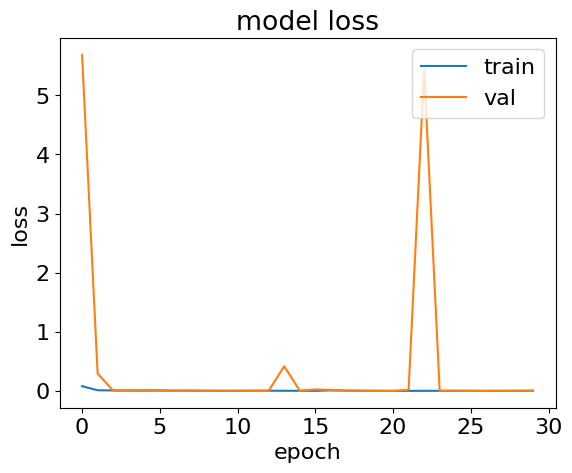

In [21]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

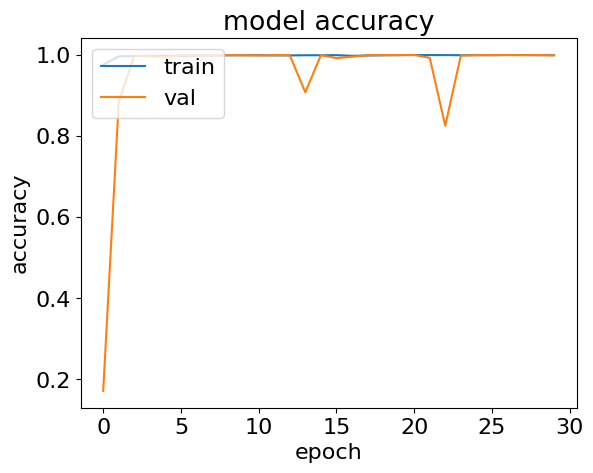

In [22]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [23]:
history.model.load_weights('best_model_cnn.h5')
test_acc = np.mean(np.argmax(history.model.predict(x_test),1)==np.argmax(y_test,1))
print('The submitted model has test accuracy equal to {}'.format(test_acc))

369/369 [==============================] - 1s 3ms/step
The submitted model has test accuracy equal to 0.9992367059621745


In [24]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

model.load_weights('best_model_cnn.h5')

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

class_labels = ['AbdomenCT', 'BreastMRI', 'ChestCT', 'CXR', 'Hand', 'HeadCT']

report = classification_report(y_true, y_pred, labels=np.arange(len(class_labels)), target_names=class_labels)
print('Classification Report for CNN')
print(report)

cm = confusion_matrix(y_true, y_pred)
print('Confusion Matrix for CNN')
print(cm)



369/369 [==============================] - 1s 2ms/step
Classification Report for CNN
              precision    recall  f1-score   support

   AbdomenCT       1.00      1.00      1.00      1964
   BreastMRI       1.00      1.00      1.00      1808
     ChestCT       1.00      1.00      1.00      2016
         CXR       1.00      1.00      1.00      1993
        Hand       1.00      1.00      1.00      2001
      HeadCT       1.00      1.00      1.00      2009

    accuracy                           1.00     11791
   macro avg       1.00      1.00      1.00     11791
weighted avg       1.00      1.00      1.00     11791

Confusion Matrix for CNN
[[1964    0    0    0    0    0]
 [   0 1808    0    0    0    0]
 [   0    0 2016    0    0    0]
 [   0    0    0 1993    0    0]
 [   0    1    5    2 1992    1]
 [   0    0    0    0    0 2009]]


**Transfer Learning**

VGG

In [25]:
# import libraries
from tensorflow import keras
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [26]:
base_model = VGG16(
    weights='imagenet',
    input_shape=(32, 32, 3),
    include_top=False)

# Freeze base model
base_model.trainable =  False

# add layers to base model
inputs = keras.Input(shape=(32, 32, 3))

x = base_model(inputs, training=False)

# Add pooling layer or flatten layer
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
 # x = keras.layers.GlobalAveragePooling2D()(x)

# Add final dense layer
outputs = keras.layers.Dense(6, activation = 'softmax')(x)

# Combine inputs and outputs to create model
model = keras.Model(inputs,outputs)

58889256/58889256 [==============================] - 0s 0us/step


In [27]:
adam = Adam(learning_rate=0.001)
save_model = ModelCheckpoint('best_model_vgg.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=2)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_val, y_val), shuffle = True, verbose=1, callbacks=[save_model])

Epoch 1/10
332/332 [==============================] - ETA: 0s - loss: 0.1094 - accuracy: 0.9660
Epoch 1: val_loss improved from inf to 0.02795, saving model to best_model_vgg.h5
332/332 [==============================] - 11s 26ms/step - loss: 0.1094 - accuracy: 0.9660 - val_loss: 0.0279 - val_accuracy: 0.9911
Epoch 2/10
331/332 [============================>.] - ETA: 0s - loss: 0.0201 - accuracy: 0.9941
Epoch 2: val_loss improved from 0.02795 to 0.01319, saving model to best_model_vgg.h5
332/332 [==============================] - 8s 23ms/step - loss: 0.0201 - accuracy: 0.9941 - val_loss: 0.0132 - val_accuracy: 0.9962
Epoch 3/10
332/332 [==============================] - ETA: 0s - loss: 0.0112 - accuracy: 0.9969
Epoch 3: val_loss improved from 0.01319 to 0.00673, saving model to best_model_vgg.h5
332/332 [==============================] - 7s 22ms/step - loss: 0.0112 - accuracy: 0.9969 - val_loss: 0.0067 - val_accuracy: 0.9992
Epoch 4/10
331/332 [============================>.] - ETA: 0s

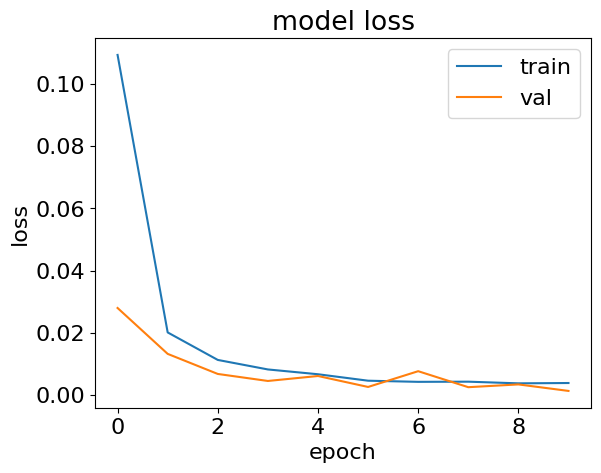

In [28]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

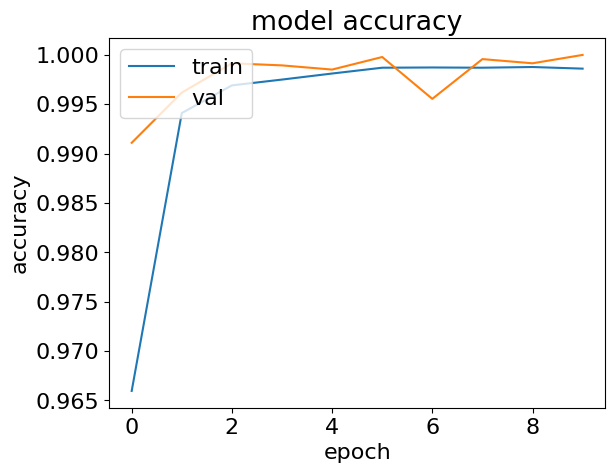

In [29]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [30]:
history.model.load_weights('best_model_vgg.h5')
test_acc = np.mean(np.argmax(history.model.predict(x_test),-1)==np.argmax(y_test,1))
print('The submitted model has test accuracy equal to {}'.format(test_acc))

369/369 [==============================] - 3s 8ms/step
The submitted model has test accuracy equal to 0.9988974641675854


In [31]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

model.load_weights('best_model_vgg.h5')

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

class_labels = ['AbdomenCT', 'BreastMRI', 'ChestCT', 'CXR', 'Hand', 'HeadCT']

report = classification_report(y_true, y_pred, labels=np.arange(len(class_labels)), target_names=class_labels)
print('Classification Report for VGG')
print(report)

cm = confusion_matrix(y_true, y_pred)
print('Confusion Matrix for VGG')
print(cm)

369/369 [==============================] - 4s 11ms/step
Classification Report for VGG
              precision    recall  f1-score   support

   AbdomenCT       1.00      1.00      1.00      1964
   BreastMRI       1.00      1.00      1.00      1808
     ChestCT       1.00      1.00      1.00      2016
         CXR       1.00      1.00      1.00      1993
        Hand       1.00      1.00      1.00      2001
      HeadCT       1.00      1.00      1.00      2009

    accuracy                           1.00     11791
   macro avg       1.00      1.00      1.00     11791
weighted avg       1.00      1.00      1.00     11791

Confusion Matrix for VGG
[[1959    0    1    0    0    4]
 [   0 1808    0    0    0    0]
 [   1    0 2015    0    0    0]
 [   0    0    0 1992    1    0]
 [   0    1    0    2 1995    3]
 [   0    0    0    0    0 2009]]


**Resnet50**

In [32]:
classes = 6
batch = 128
epochs = 10
learning_rate = 0.001

In [33]:
# build model architecture
model = Sequential()
model.add(ResNet50(weights='imagenet', include_top=False, input_shape=(32,32,3)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(6, activation='softmax'))

94765736/94765736 [==============================] - 1s 0us/step


In [34]:
adam = Adam(learning_rate)
save_model = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=2)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_val, y_val), shuffle = True, verbose=1, callbacks=[save_model])

Epoch 1/10
332/332 [==============================] - ETA: 0s - loss: 0.0265 - accuracy: 0.9935
Epoch 1: val_loss improved from inf to 35.61461, saving model to best_model.h5
332/332 [==============================] - 74s 89ms/step - loss: 0.0265 - accuracy: 0.9935 - val_loss: 35.6146 - val_accuracy: 0.1709
Epoch 2/10
332/332 [==============================] - ETA: 0s - loss: 0.0268 - accuracy: 0.9947
Epoch 2: val_loss improved from 35.61461 to 2.36546, saving model to best_model.h5
332/332 [==============================] - 26s 78ms/step - loss: 0.0268 - accuracy: 0.9947 - val_loss: 2.3655 - val_accuracy: 0.4825
Epoch 3/10
332/332 [==============================] - ETA: 0s - loss: 0.0034 - accuracy: 0.9992
Epoch 3: val_loss did not improve from 2.36546
332/332 [==============================] - 21s 62ms/step - loss: 0.0034 - accuracy: 0.9992 - val_loss: 3.1438 - val_accuracy: 0.7511
Epoch 4/10
332/332 [==============================] - ETA: 0s - loss: 0.0073 - accuracy: 0.9986
Epoch 4

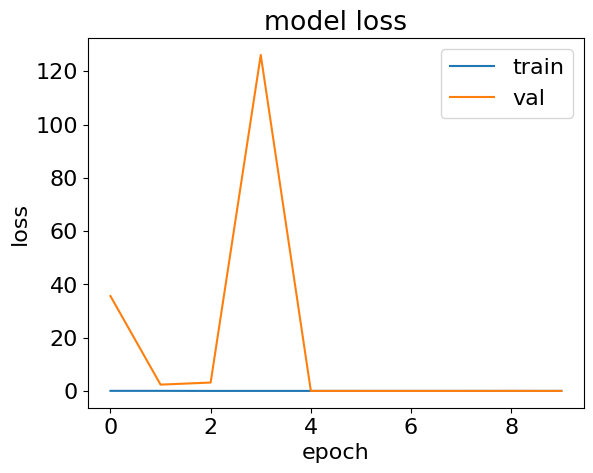

In [35]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

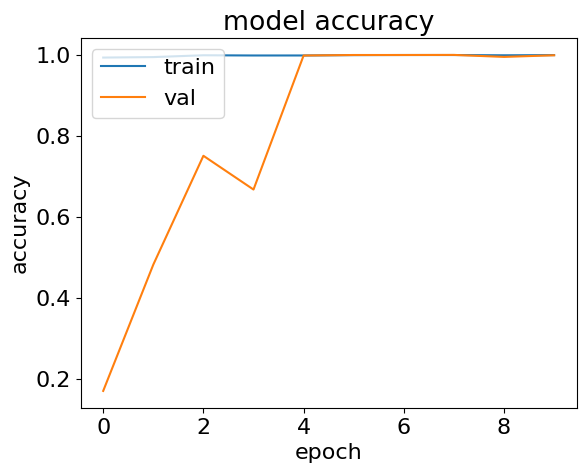

In [36]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [37]:
history.model.load_weights('best_model.h5')
test_acc = np.mean(np.argmax(history.model.predict(x_test),-1)==np.argmax(y_test,1))
print('The submitted model has test accuracy equal to {}'.format(test_acc))

369/369 [==============================] - 6s 11ms/step
The submitted model has test accuracy equal to 0.9998303791027054


In [38]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

model.load_weights('best_model.h5')

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

class_labels = ['AbdomenCT', 'BreastMRI', 'ChestCT', 'CXR', 'Hand', 'HeadCT']

report = classification_report(y_true, y_pred, labels=np.arange(len(class_labels)), target_names=class_labels)
print('Classification Report for ResNet50')
print(report)

cm = confusion_matrix(y_true, y_pred)
print('Confusion Matrix for ResNet50')
print(cm)

369/369 [==============================] - 3s 9ms/step
Classification Report for ResNet50
              precision    recall  f1-score   support

   AbdomenCT       1.00      1.00      1.00      1964
   BreastMRI       1.00      1.00      1.00      1808
     ChestCT       1.00      1.00      1.00      2016
         CXR       1.00      1.00      1.00      1993
        Hand       1.00      1.00      1.00      2001
      HeadCT       1.00      1.00      1.00      2009

    accuracy                           1.00     11791
   macro avg       1.00      1.00      1.00     11791
weighted avg       1.00      1.00      1.00     11791

Confusion Matrix for ResNet50
[[1964    0    0    0    0    0]
 [   0 1808    0    0    0    0]
 [   0    0 2016    0    0    0]
 [   0    0    0 1993    0    0]
 [   0    0    0    2 1999    0]
 [   0    0    0    0    0 2009]]


Image Augmentation

In [39]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


base_model = VGG16(
    weights='imagenet',
    input_shape=(32, 32, 3),
    include_top=False)

# Freeze base model
base_model.trainable =  False

# add layers to base model
inputs = keras.Input(shape=(32, 32, 3))

x = base_model(inputs, training=False)

# Add pooling layer or flatten layer
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
# x = keras.layers.GlobalAveragePooling2D()(x)

# Add final dense layer
outputs = keras.layers.Dense(6, activation = 'softmax')(x)

# Combine inputs and outputs to create model
model = keras.Model(inputs,outputs)

adam = Adam(learning_rate=0.001)
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        rotation_range= 0,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images horizontally
        vertical_flip=True) # randomly flip images vertically

datagen.fit(x_train)

In [40]:
save_model = ModelCheckpoint('best_model_vggaug.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=2)

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(datagen.flow(x_train, y_train, batch_size=128),
          steps_per_epoch=len(x_train) / 128, epochs=20, validation_data=(x_val, y_val), shuffle = True, callbacks=[save_model])

Epoch 1/20
332/331 [==============================] - ETA: 0s - loss: 0.1389 - accuracy: 0.9558
Epoch 1: val_loss improved from inf to 0.03931, saving model to best_model_vggaug.h5
331/331 [==============================] - 33s 95ms/step - loss: 0.1389 - accuracy: 0.9558 - val_loss: 0.0393 - val_accuracy: 0.9837
Epoch 2/20
332/331 [==============================] - ETA: 0s - loss: 0.0402 - accuracy: 0.9861
Epoch 2: val_loss improved from 0.03931 to 0.03203, saving model to best_model_vggaug.h5
331/331 [==============================] - 28s 84ms/step - loss: 0.0402 - accuracy: 0.9861 - val_loss: 0.0320 - val_accuracy: 0.9877
Epoch 3/20
332/331 [==============================] - ETA: 0s - loss: 0.0293 - accuracy: 0.9897
Epoch 3: val_loss improved from 0.03203 to 0.02140, saving model to best_model_vggaug.h5
331/331 [==============================] - 28s 84ms/step - loss: 0.0293 - accuracy: 0.9897 - val_loss: 0.0214 - val_accuracy: 0.9922
Epoch 4/20
332/331 [==============================

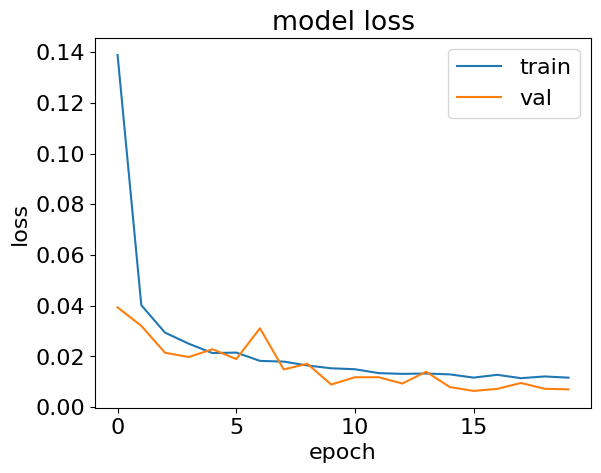

In [41]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

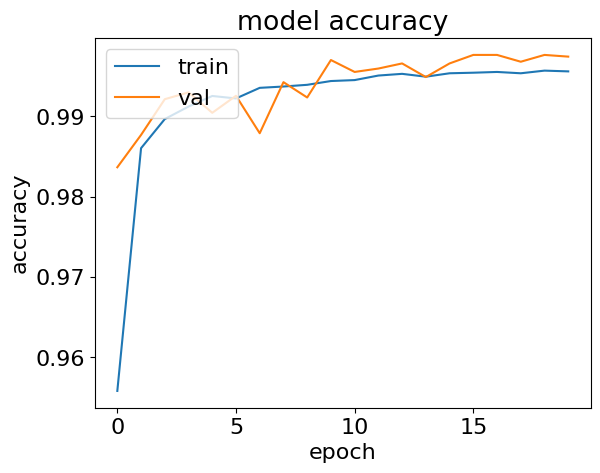

In [42]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [43]:
history.model.load_weights('best_model_vggaug.h5')
test_acc = np.mean(np.argmax(history.model.predict(x_test),-1)==np.argmax(y_test,1))
print('The submitted model has test accuracy equal to {}'.format(test_acc))

369/369 [==============================] - 3s 7ms/step
The submitted model has test accuracy equal to 0.9977101178865236


In [44]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

model.load_weights('best_model_vggaug.h5')

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

class_labels = ['AbdomenCT', 'BreastMRI', 'ChestCT', 'CXR', 'Hand', 'HeadCT']

report = classification_report(y_true, y_pred, labels=np.arange(len(class_labels)), target_names=class_labels)
print('Classification Report for VGG AUG')
print(report)

cm = confusion_matrix(y_true, y_pred)
print('Confusion Matrix for VGG AUG')
print(cm)

369/369 [==============================] - 3s 8ms/step
Classification Report for VGG AUG
              precision    recall  f1-score   support

   AbdomenCT       0.99      0.99      0.99      1964
   BreastMRI       1.00      1.00      1.00      1808
     ChestCT       0.99      1.00      1.00      2016
         CXR       1.00      1.00      1.00      1993
        Hand       1.00      1.00      1.00      2001
      HeadCT       1.00      1.00      1.00      2009

    accuracy                           1.00     11791
   macro avg       1.00      1.00      1.00     11791
weighted avg       1.00      1.00      1.00     11791

Confusion Matrix for VGG AUG
[[1953    0   11    0    0    0]
 [   1 1807    0    0    0    0]
 [   9    0 2007    0    0    0]
 [   0    0    0 1991    2    0]
 [   0    0    0    2 1997    2]
 [   0    0    0    0    0 2009]]
